### load the dataset

In [74]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import cufflinks as cf
from wordcloud import WordCloud
from collections import defaultdict
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, utils

In [2]:
train = pd.read_csv('training_data.csv', low_memory=False)
test = pd.read_csv('test_data.csv')

In [3]:
train.isnull().sum()

text                         0
reply_to_screen_name    227937
is_quote                     0
is_retweet                   0
hashtags                     0
country                      0
dtype: int64

In [4]:
test.isnull().sum()

text                        0
reply_to_screen_name    56907
is_quote                    0
is_retweet                  0
hashtags                    0
Id                          0
dtype: int64

In [5]:
train.drop('reply_to_screen_name', axis=1, inplace=True)
test.drop('reply_to_screen_name', axis=1, inplace=True)
train = train[train['is_quote']!= "Colin o'donoghue"]

In [6]:
test.head()

,text,is_quote,is_retweet,hashtags,Id
0,"Ethical investing is not optional anymore, say...",False,False,covid19,0
1,#COVID19 | Suite à la conférence de presse du ...,False,True,COVID19,1
2,"Yesterday, I had a live discussion with @Steve...",False,True,COVID19,2
3,Nepal - #Coronavirus cases up 24% in a week. D...,False,True,Coronavirus,3
4,American economy jumped up a % big news story...,False,False,LysolAndCloroxSales,4


In [7]:
train.head()

,text,is_quote,is_retweet,hashtags,country
0,Remember the #WuhanCoronaVirus? The pandemic w...,FALSE,TRUE,WuhanCoronaVirus KillerCuomo,us
1,My sources @WhiteHouse say 2 tactics will be u...,FALSE,TRUE,Trump,us
2,I'll venture a wild guess: If you were running...,FALSE,TRUE,COVID19,us
3,#Pakistan (#GreenStimulus = #Nature protection...,FALSE,TRUE,Pakistan GreenStimulus Nature Green,us
4,🇺🇸 Pandémie de #coronavirus: 30 pasteurs améri...,FALSE,TRUE,coronavirus COVID__19 COVIDー19,us


In [8]:
test['is_quote'].unique()

array([False,  True])

In [9]:
test['is_retweet'].unique()

array([False,  True])

### clean the data: remove url

In [10]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [11]:
train['text'][5] 

'So I made a meme....#corona #virus #meme #coronavirusmeme #toilet #paper #coronapocalypse https://t.co/1qpLSe2oPj'

In [12]:
train['text'] = train['text'].apply(remove_url)
test['text'] = test['text'].apply(remove_url)

In [13]:
train['text'].apply(remove_url)[5] # it works

'So I made a meme....#corona #virus #meme #coronavirusmeme #toilet #paper #coronapocalypse '

### clean the data: remove HTML

In [14]:
def remove_HTML(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

In [15]:
train['text'] = train['text'].apply(remove_HTML)
test['text'] = test['text'].apply(remove_HTML)

### clean the data: remove emojis

In [16]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [17]:
train['text'][4]

'🇺🇸 Pandémie de #coronavirus: 30 pasteurs américains qui avaient minimisé le #COVID__19 sont morts du #COVIDー19. Certains, dont la communauté afro-américaine "Church of God in Christ", continuaient d\'organiser des cultes malgré les avertissements. (Independent) #ConfinementJour44'

In [18]:
train['text'] = train['text'].apply(remove_emojis)
test['text'] = test['text'].apply(remove_emojis)

In [19]:
train['text'][4] 

' Pandémie de #coronavirus: 30 pasteurs américains qui avaient minimisé le #COVID__19 sont morts du #COVID19. Certains, dont la communauté afro-américaine "Church of God in Christ", continuaient d\'organiser des cultes malgré les avertissements. (Independent) #ConfinementJour44'

### clean the data: remove punctuation

In [20]:
def remove_punctuation(text):
    punc = str.maketrans('', '', string.punctuation)
    return text.translate(punc)

In [21]:
train['text'][4]

' Pandémie de #coronavirus: 30 pasteurs américains qui avaient minimisé le #COVID__19 sont morts du #COVID19. Certains, dont la communauté afro-américaine "Church of God in Christ", continuaient d\'organiser des cultes malgré les avertissements. (Independent) #ConfinementJour44'

In [22]:
train['text'] = train['text'].apply(remove_punctuation)
test['text'] = test['text'].apply(remove_punctuation)

In [23]:
train['text'][0]

'Remember the WuhanCoronaVirus The pandemic where a great percentage of the deaths resulted from KillerCuomo’s nursing home slaughter The one where we were quarantined by Democrats It’ll be back rest assured as soon as the riots stop Anything to destroy Trump'

### check the wordcloud again

In [24]:
def create_corpus(data, country):
    corpus = []
    for i in data[data['country']==country]['text']:
        for j in i.split():
            corpus.append(j)
    return corpus

In [25]:
def build_wordcloud(data, country):
    corpus = create_corpus(data, country)
    wordcloud = WordCloud(background_color = 'white', height=800, width=1500, colormap='viridis').generate(' '.join(corpus))
    plt.imshow(wordcloud)
    fig = plt.gcf()
    fig.set_size_inches(12,8)

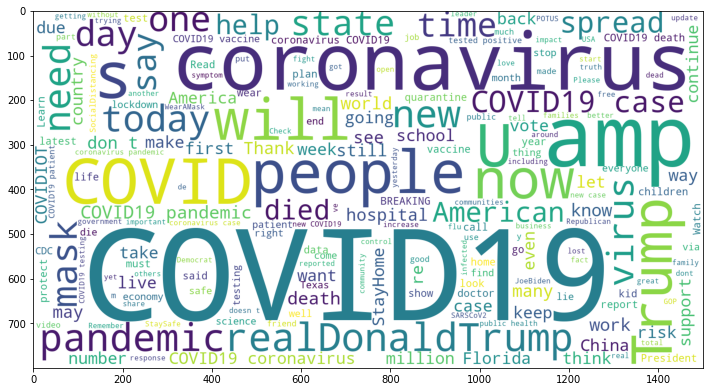

In [26]:
build_wordcloud(train, 'us')

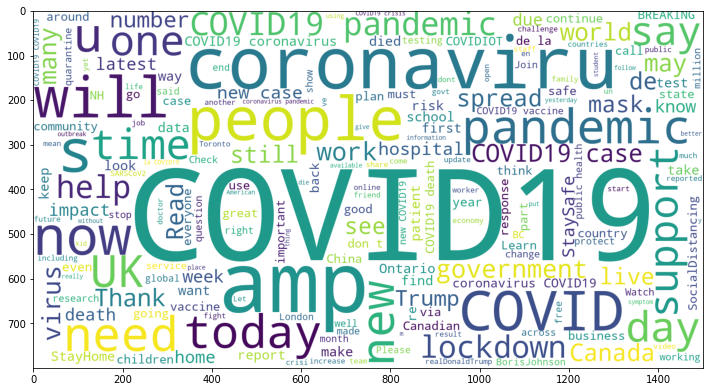

In [27]:
build_wordcloud(train, 'canada')

### build the model

In [177]:
corpus = []
ps = PorterStemmer()
for i in train['text']:
    text = i.lower()
    text = text.split()
    text = [ps.stem(word) for word in text]
    text = ', '.join(text)
    corpus.append(text)

In [42]:
corpus[0]

'rememb, the, wuhancoronaviru, the, pandem, where, a, great, percentag, of, the, death, result, from, killercuomo’, nurs, home, slaughter, the, one, where, we, were, quarantin, by, democrat, it’ll, be, back, rest, assur, as, soon, as, the, riot, stop, anyth, to, destroy, trump'

In [44]:
Tok = Tokenizer(num_words = 5000)

In [46]:
Tok.fit_on_texts(corpus)

In [48]:
sequences = Tok.texts_to_sequences(corpus)

In [178]:
embedding_docs = pad_sequences(sequences, maxlen=25)

In [135]:
corpus_hash = []
ps = PorterStemmer()
for i in train['hashtags']:
    text = i.lower()
    text = text.split()
    text = [ps.stem(word) for word in text]
    text = ', '.join(text)
    corpus_hash.append(text)

In [139]:
corpus_hash[0]

'wuhancoronaviru, killercuomo'

In [161]:
Tok.fit_on_texts(corpus_hash)
sequences_hash = Tok.texts_to_sequences(corpus_hash)
embedding_docs_hash = pad_sequences(sequences_hash, maxlen=12)

In [163]:
embedding_docs_hash.shape

(239999, 12)

In [179]:
embedding_docs = np.concatenate((embedding_docs,embedding_docs_hash), axis=1)

In [180]:
embedding_docs.shape

(239999, 37)

In [170]:
train['country'].unique()

array(['us', 'uk', 'canada', 'australia', 'ireland', 'new_zealand'],
      dtype=object)

In [171]:
scale = {'us':1, 'uk':2, 'canada':3, 'australia':4, 'ireland':5, 'new_zealand':6}

In [172]:
ytrain = train['country'].replace(scale)

In [173]:
label = utils.to_categorical(ytrain)

In [174]:
label = label[:,1:]

In [183]:
model = models.Sequential()
model.add(layers.Embedding(5000, 40, input_length=37))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(400))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 37, 40)            200000    
                                                                 
 dropout_20 (Dropout)        (None, 37, 40)            0         
                                                                 
 lstm_10 (LSTM)              (None, 400)               705600    
                                                                 
 dropout_21 (Dropout)        (None, 400)               0         
                                                                 
 dense_10 (Dense)            (None, 6)                 2406      
                                                                 
Total params: 908,006
Trainable params: 908,006
Non-trainable params: 0
_________________________________________________________________


In [184]:
Xtrain, Xtest, ytrain, ytest = train_test_split(embedding_docs, label)

In [185]:
model.fit(Xtrain, ytrain, epochs=20, batch_size=40, validation_data=(Xtest, ytest))

Epoch 1/20
4500/4500 [==============================] - 443s 98ms/step - loss: 1.6557 - acc: 0.2902 - val_loss: 1.5559 - val_acc: 0.3571
Epoch 2/20
4500/4500 [==============================] - 387s 86ms/step - loss: 1.5360 - acc: 0.3697 - val_loss: 1.5084 - val_acc: 0.3822
Epoch 3/20
4500/4500 [==============================] - 385s 86ms/step - loss: 1.4970 - acc: 0.3921 - val_loss: 1.4929 - val_acc: 0.3911
Epoch 4/20
4500/4500 [==============================] - 388s 86ms/step - loss: 1.4738 - acc: 0.4053 - val_loss: 1.4834 - val_acc: 0.3956
Epoch 5/20
4500/4500 [==============================] - 6617s 1s/step - loss: 1.4587 - acc: 0.4126 - val_loss: 1.4802 - val_acc: 0.3969
Epoch 6/20
4500/4500 [==============================] - 693s 154ms/step - loss: 1.4445 - acc: 0.4208 - val_loss: 1.4820 - val_acc: 0.3993
Epoch 7/20
4500/4500 [==============================] - 439s 97ms/step - loss: 1.4306 - acc: 0.4279 - val_loss: 1.4806 - val_acc: 0.4036
Epoch 8/20
4500/4500 [===================